In [1]:
import numpy as np
timeStamp  = np.array([0.5,1,2,3,4,5,7,10])
CDSspreadI = np.array([172.9, 173.7, 155.5, 152.3, 144.0, 142.3, 148.3, 156.4])/10000

In [2]:
def li(t):
        try:
            return CDSspreadI[np.where(timeStamp > t )][0]
        except:
            return CDSspreadI[0]


In [8]:
from joblib import load
from defaultCurves import *
from HullWhite import *

beta = np.array([1.879892, 0.579211, 	3.993992, 1.445091])
tau  = np.array([ 16.633491, 	0.319680])
reversion=0.13949636660880768 
volatility=0.017793899652989272
# HW = HullWhite(initial=0.02459103, reversion=0.03, volatility=0.00200, Gamma=1000, b=beta, tau=tau)
HW = HullWhite(initial=0.02459103, reversion=reversion, volatility=volatility, b=beta, tau=tau)
time = HW.create_path(1/4,10)[0]

# NE = load('./SimulationData/NE_10Y_Swap_N=5000_dt=4.joblib')

# PE = load('./SimulationData/PE_10Y_Swap_N=5000_dt=4.joblib')
dt = 1/4
sum = 0
lag = 2/365
time
# for i in range(len(time)):
#     sum += PE[i]*SI(time[i])*(QC(time[i])-QC(time[i]-dt))

# CVA = -sum

# sum = 0
# for i in range(len(time)):
#     sum += NE[i]*SC(time[i])*(QI(time[i])-QI(time[i]-dt))

# DVA = -sum

# print(CVA, DVA)

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  ])

In [9]:
time

# Compute the values to insert
values_to_insert = time[1::] - lag

# Insert the values before each element in the original array
len(np.insert(time, np.arange(1,len(time)), values_to_insert)), len(time)

(81, 41)

In [10]:
time = np.arange(0,10+dt,dt)

#Constructing lagged grid
lagged_time = (time-lag)[np.where(time-lag > 0)]
ttso = np.insert(time, np.arange(1,len(time)), lagged_time)

In [11]:
ttso

array([ 0.        ,  0.24452055,  0.25      ,  0.49452055,  0.5       ,
        0.74452055,  0.75      ,  0.99452055,  1.        ,  1.24452055,
        1.25      ,  1.49452055,  1.5       ,  1.74452055,  1.75      ,
        1.99452055,  2.        ,  2.24452055,  2.25      ,  2.49452055,
        2.5       ,  2.74452055,  2.75      ,  2.99452055,  3.        ,
        3.24452055,  3.25      ,  3.49452055,  3.5       ,  3.74452055,
        3.75      ,  3.99452055,  4.        ,  4.24452055,  4.25      ,
        4.49452055,  4.5       ,  4.74452055,  4.75      ,  4.99452055,
        5.        ,  5.24452055,  5.25      ,  5.49452055,  5.5       ,
        5.74452055,  5.75      ,  5.99452055,  6.        ,  6.24452055,
        6.25      ,  6.49452055,  6.5       ,  6.74452055,  6.75      ,
        6.99452055,  7.        ,  7.24452055,  7.25      ,  7.49452055,
        7.5       ,  7.74452055,  7.75      ,  7.99452055,  8.        ,
        8.24452055,  8.25      ,  8.49452055,  8.5       ,  8.74

In [12]:
np.random.seed(0)
T=np.arange(0,10+0.5,0.5)
S=np.arange(0,11,1)
K=fsolve(lambda x: HW.swap(0, S, T, x), x0=0.02)[0]
swap1 = []
for s in range(1000):
    float = [HW.init]
    for i in range(1, len(ttso)):
        ss=ttso[i]-ttso[i-1] #stepsize
        float.append(HW.oneStep(t=ttso[i], stepfrom=float[i-1], stepsize=ss, fwd=0))

    if dt==1/365:
        lagged_float = np.array(float[0:len(float)-2])
        float = np.array(float)
    else:
        lagged_float = np.array(float[1::2])
        float = np.array(float[0::2])

    swap1.append(np.array([HW.swapextended(x[0], S, T, K=K, floatRate=float, schedule=time, initRate=x[1]) for x in np.array([time,float]).T]))


swap2 =[]
for s in range(1000):
    time, float = HW.create_path(dt,10)
    swap2.append(np.array([HW.swapextended(x[0], S, T, K=K, floatRate=float, schedule=time, initRate=x[1]) for x in np.array([time,float]).T]))


In [ ]:
lagged_time

In [21]:
for t in enumerate(time):
    if t[0]==0:
        continue
    print(lagged_time[t[0]-1])
lagged_time

0.24452054794520547
0.4945205479452055
0.7445205479452055
0.9945205479452055
1.2445205479452055
1.4945205479452055
1.7445205479452055
1.9945205479452055
2.2445205479452053
2.4945205479452053
2.7445205479452053
2.9945205479452053
3.2445205479452053
3.4945205479452053
3.7445205479452053
3.9945205479452053
4.244520547945205
4.494520547945205
4.744520547945205
4.994520547945205
5.244520547945205
5.494520547945205
5.744520547945205
5.994520547945205
6.244520547945205
6.494520547945205
6.744520547945205
6.994520547945205
7.244520547945205
7.494520547945205
7.744520547945205
7.994520547945205
8.244520547945205
8.494520547945205
8.744520547945205
8.994520547945205
9.244520547945205
9.494520547945205
9.744520547945205
9.994520547945205


array([0.24452055, 0.49452055, 0.74452055, 0.99452055, 1.24452055,
       1.49452055, 1.74452055, 1.99452055, 2.24452055, 2.49452055,
       2.74452055, 2.99452055, 3.24452055, 3.49452055, 3.74452055,
       3.99452055, 4.24452055, 4.49452055, 4.74452055, 4.99452055,
       5.24452055, 5.49452055, 5.74452055, 5.99452055, 6.24452055,
       6.49452055, 6.74452055, 6.99452055, 7.24452055, 7.49452055,
       7.74452055, 7.99452055, 8.24452055, 8.49452055, 8.74452055,
       8.99452055, 9.24452055, 9.49452055, 9.74452055, 9.99452055])

<Axes: >

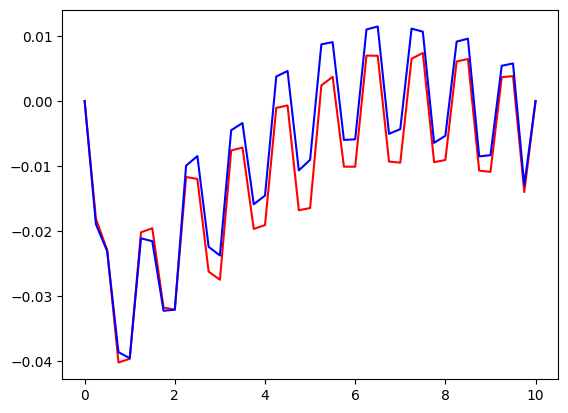

In [13]:
sns.lineplot(x=time, y=np.sum(swap1, axis=0)/1000, color='red')
sns.lineplot(x=time, y=np.sum(swap2, axis=0)/1000, color='blue')

In [85]:
for i in range(1, len(ttso)):
    print(i, ttso[i]-ttso[i-1])

1 0.24452054794520547
2 0.005479452054794526
3 0.2445205479452055
4 0.005479452054794498
5 0.2445205479452055
6 0.005479452054794498
7 0.2445205479452055
8 0.005479452054794498
9 0.2445205479452055
10 0.005479452054794498
11 0.2445205479452055
12 0.005479452054794498
13 0.2445205479452055
14 0.005479452054794498
15 0.2445205479452055
16 0.005479452054794498
17 0.24452054794520528
18 0.00547945205479472
19 0.24452054794520528
20 0.00547945205479472
21 0.24452054794520528
22 0.00547945205479472
23 0.24452054794520528
24 0.00547945205479472
25 0.24452054794520528
26 0.00547945205479472
27 0.24452054794520528
28 0.00547945205479472
29 0.24452054794520528
30 0.00547945205479472
31 0.24452054794520528
32 0.00547945205479472
33 0.24452054794520528
34 0.00547945205479472
35 0.24452054794520528
36 0.00547945205479472
37 0.24452054794520528
38 0.00547945205479472
39 0.24452054794520528
40 0.00547945205479472
41 0.24452054794520528
42 0.00547945205479472
43 0.24452054794520528
44 0.00547945205479

In [73]:
swap[0]+swap[1]+swap[2]

array([ 0.        , -0.02926022,  0.06235695,  0.10527587,  0.13395705,
        0.20223135,  0.25053896,  0.25561583,  0.25849017,  0.30895182,
        0.31061921,  0.20672362,  0.15960259,  0.22308006,  0.17048366,
        0.19778955,  0.22162331,  0.21345416,  0.22710578,  0.23264973,
        0.32240429,  0.31874546,  0.33564718,  0.22395078,  0.19312712,
        0.18630354,  0.17658564,  0.08720313,  0.05892699,  0.09548195,
        0.12672347,  0.0216475 ,  0.00354934,  0.03874321,  0.01437337,
       -0.06229439, -0.06650842, -0.02206412, -0.02612848, -0.0630279 ,
        0.        ])

[0.02459103,
 0.006431273772554567,
 0.0034839811958045238,
 -0.016463645289327224,
 -0.019447672955066924,
 -0.038805137192876094,
 -0.041775856365345296,
 -0.060021695846151205,
 -0.06296827587145624,
 -0.08012988857507143,
 -0.08305304101873417,
 -0.09927122831429577,
 -0.10217401376169191,
 -0.11757824787153275,
 -0.12046345578251157,
 -0.13514889650918133,
 -0.13801857204771062,
 -0.1520511492996072,
 -0.15490670890284422,
 -0.16833258941012852,
 -0.17117502569449303,
 -0.18402821716242784,
 -0.18685826235146014,
 -0.19916559575731857,
 -0.20198382845868715,
 -0.21376793112152953,
 -0.2165748399485151,
 -0.2278558188074388,
 -0.2306518383678861,
 -0.24144820350577845,
 -0.24423373413698407,
 -0.2545628969437392,
 -0.2573383153553549,
 -0.2672168563589029,
 -0.26998252135553014,
 -0.2794263361813733,
 -0.282182591782875,
 -0.29120697366473935,
 -0.2939541508721443,
 -0.3025738404712525,
 -0.3053122583349294,
 -0.31354147678542155,
 -0.31627144311525274,
 -0.324123916425341,
 -0.326

In [85]:
T=np.arange(0,10+0.5,0.5)
S=np.arange(0,11,1)
K=fsolve(lambda x: HW.swap(0, S, T, x), x0=0.02)[0]
if dt==1/365:
    lagged_float = np.array(float[0:len(float)-2])
    float = np.array(float)
else:
    lagged_float = np.array(float[1::2])
    float = np.array(float[0::2])

swap = np.array([HW.swapextended(x[0], S, T, K=K, floatRate=float, schedule=time, initRate=x[1]) for x in np.array([time,float]).T])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [81]:
np.where(ttso-lagged_time == 0)

ValueError: operands could not be broadcast together with shapes (81,) (40,) 

<Axes: >

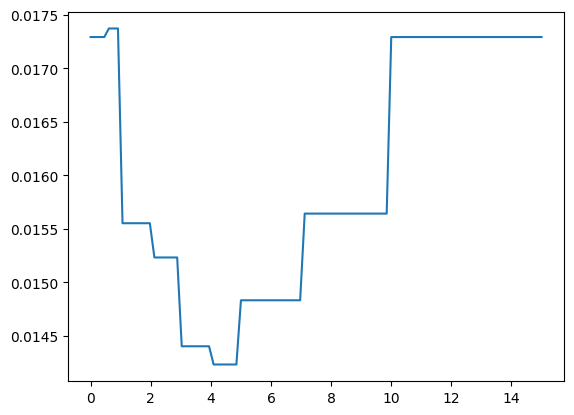

In [22]:
import seaborn as sns

sns.lineplot(x=np.linspace(0, 15, 100), y=[li(x) for x in np.linspace(0, 15, 100)])